## Introduction

The Tektronix AWG70000A series internally use `.seqx` files. The QCoDeS driver for the AWGs knows how to compile these files and broadbean knows what QCoDeS need to do so. 

### Step 1: Make a sequence

In [13]:
# We make a sequence consisting of a bsic element with:
# a wait time, a ramp up, a sine, a ramp down, and more wait time
# And then we vary the sine frequency
%matplotlib notebook
import broadbean as bb
from broadbean.plotting import plotter
import numpy as np

sine = bb.PulseAtoms.sine
ramp = bb.PulseAtoms.ramp

##########################
# settings

SR = 25e9
t1 = 10e-9  # first wait time (s)
ramp_time = 5e-9  # the ramp time (s)
t_sine = 25e-9  # the sine time (s)
high_level = 0.1  # the high level (V)
sine_amp = 0.05  # the sine amplitude (V)
t2 = 150e-9  # the second wait time (s)
f0 = 3e8  # the base frequency of the sine (Hz)

baseshape = bb.BluePrint()
baseshape.insert_segment(0, ramp, (0, 0), dur=t1)
baseshape.insert_segment(1, ramp, (0, high_level), dur=ramp_time)
baseshape.insert_segment(2, sine, (f0, sine_amp, high_level, 0), dur=t_sine, name='drive')
baseshape.insert_segment(3, ramp, (high_level, 0), dur=ramp_time)
baseshape.insert_segment(4, ramp, (0, 0), dur=t2, name='wait')
baseshape.set_segment_marker('wait', (0, t_sine), 1)
baseshape.set_segment_marker('drive', (0, t_sine), 2)
baseshape.set_sample_rate(SR)

<IPython.core.display.Javascript object>


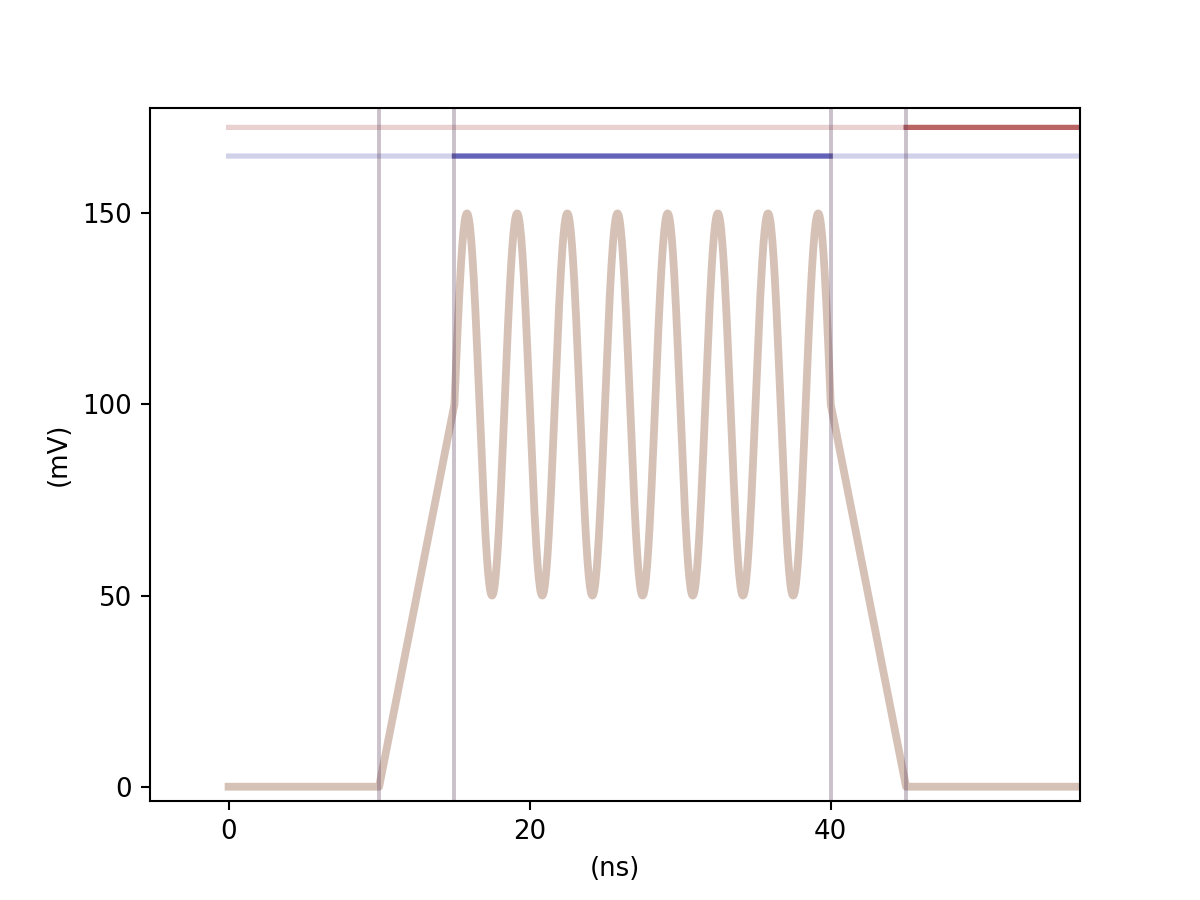

In [14]:
# Check that it looks the way we expect
plotter(baseshape)

In [7]:
# Make it into a sequence
baseelem = bb.Element()
baseelem.addBluePrint(1, baseshape)

# Add elements and vary the sine freq.

sine_freqs = np.linspace(1e9, 2e9, 5)

seq = bb.Sequence()
seq.setSR(SR)

# We set each element of the sequence to wait for
# a trigger from trigger input 'A'

for index, freq in enumerate(sine_freqs):
    elem = baseelem.copy()
    elem.changeArg(1, 'drive', 'freq', freq)
    seq.addElement(index+1, elem)
    seq.setSequencingTriggerWait(index+1, 1)  # 1: trigA, 2: trigB, 3: EXT

# and set the last element to point back to the first one
seq.setSequencingGoto(index+1, 1)

seq.name = 'tutorial_sequence'  # the sequence name will be needed later

### Step 2: Initialise the driver

In [4]:
# import and initialise the driver and ensure that the sample
# rate and channel voltage is correct

from qcodes.instrument_drivers.tektronix.AWG70002A import AWG70002A

awg = AWG70002A('awg', 'TCPIP0::172.20.2.243::inst0::INSTR')

Connected to: TEKTRONIX AWG70002A (serial:B020397, firmware:FV:5.3.0128.0) in 0.57s


In [5]:
awg.sample_rate(SR)
awg.ch1.awg_amplitude(0.5)  # this is the peak-to-peak amplitude of the channel

# Now we must update the Sequence object with this information
seq.setChannelAmplitude(1, awg.ch1.awg_amplitude())

### Step 3: Make output for the driver

In [6]:
# If the sequence has been built correctly, it's a one-liner
seqx_input = seq.outputForSEQXFile()

### Step 4: Build, send, load, and assign a .seqx file

In [7]:
# compile a binary .seqx file
seqx_output = awg.makeSEQXFile(*seqx_input)

In [8]:
# transfer it to the awg harddrive
awg.sendSEQXFile(seqx_output, 'tutorial.seqx')

In [9]:
# load it into awg active memory
awg.loadSEQXFile('tutorial.seqx')

In [10]:
# assign tracks from the sequence to the awg sequencer
awg.ch1.setSequenceTrack('tutorial_sequence', 1)

# NB: Each channel has an assigned resolution, either 8, 9, or 10.
# 8 means 8 bits for the waveform, 2 bits for the markers (i.e. 2 markers)
# 9 means 9 bits for the waveform, 1 bit for the markers (i.e. 1 marker)
# 10 means 10 bit for the waveform, no markers
#
# Since we want to have two markers, we make sure that the resolution is 8
awg.ch1.resolution(8)

### Step 5: Play it

In [11]:
awg.ch1.state(1)
awg.play()

In [12]:
# force trigger the instrument to play the next part of the sequence
awg.force_triggerA()

In [13]:
# eventually shut down and turn off
awg.stop()
awg.ch1.state(0)
awg.close()